# Federated Binary with 5 agents and first heterogenity

### (On MNIST) -- Includes comparison plots

### On bar above, navigate to Cell --> Run All. This will run all the cells.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import math
from math import *
import time
import random 
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
mnist = fetch_openml('mnist_784', version=1) #This is for fetching the MNIST data
mnist.keys()
U0, v0 = mnist["data"], mnist["target"]

C:\Users\RyanS\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
U = U0.astype(np.double) # changes the attribute values to float
v = v0.astype(np.uint8) # changes labels from string to integer
print(U.shape,"  ", v.shape)

(70000, 784)    (70000,)


In [4]:
# Change labels 
#Change the == value to an int inclusive 0 to 9 to binary classify that number
v_bin_5_lst = [2*int(v[i]==5)-1 for i in range(len(v))]   #{-1，1} for LogReg

# Data preparation: train and test data

In [5]:
# Create a single dataframe of all attributes and their labels
import pandas as pd
df_U = pd.DataFrame(data=U)
df_v = pd.DataFrame(data=np.asarray(v_bin_5_lst),  columns=['label'])
df_data_merged =pd.concat([df_U, df_v.reindex(df_U.index)], axis=1)
#df_data_merged.head(10)
#df_data_merged.info()

# Split the merged data randomly to train and test
def split_train_test(df_data_merged, train_set_size,test_set_size):
    np.random.seed(0) # use this line if you want your train and test data remain the same accross experiments
    shuffled_indices = np.random.permutation(len(df_data_merged))
    
    dic_train_set = {}
    dic_train_set_indices = shuffled_indices[:train_set_size]
    dic_train_set[0] = df_data_merged.iloc[dic_train_set_indices]
    
    dic_test_set= {}
    test_indices = shuffled_indices[-test_set_size:]
    dic_test_set[0] = df_data_merged.iloc[test_indices]
    
    return dic_train_set, dic_test_set

# Split the train or test data to U_train and v_train
def split_train_or_test_df_to_U_v(train_or_test_df):
    npar_data= (train_or_test_df).to_numpy()
    nparr_data_transp = npar_data.T
    U_output = nparr_data_transp[:-1,:]
    v_output =nparr_data_transp[-1:,:]
    return U_output,v_output

In [6]:
train_set_size,test_set_size = 10000,100  # you can adjust the train size here

dic_train_set, dic_test_set = split_train_test(df_data_merged, train_set_size,test_set_size)
#dic_train_set[0].head()

U_train,v_train = split_train_or_test_df_to_U_v(dic_train_set[0]) #Training Variables
n_train , N_train = np.shape(U_train)

U_test,v_test = split_train_or_test_df_to_U_v(dic_test_set[0]) #Testing variables
n_test , N_test = np.shape(U_test)

n = n_train # dimension / features
N = N_train # observations / samples

print(n,N)
print(U_train.shape,v_train.shape)

784 10000
(784, 10000) (1, 10000)


In [7]:
U_trains = {}

U_trains[0] = U_train[:,0:1000]
U_trains[1] = U_train[:,1000:2000]
U_trains[2] = U_train[:,2000:4000]
U_trains[3] = U_train[:,4000:7000]
U_trains[4] = U_train[:,7000:10000]

In [8]:
v_trains = {}

v_trains[0] = v_train[:,0:1000]
v_trains[1] = v_train[:,1000:2000]
v_trains[2] = v_train[:,2000:4000]
v_trains[3] = v_train[:,4000:7000]
v_trains[4] = v_train[:,7000:10000]

weights = {0: .100, 1: .100, 2: .200, 3: .300, 4: .300}

# Gradient Descent Code

In [9]:
def SGD(x0, step_size, kmax, H, epoch):
    xnow = x0
    value = np.zeros(epoch+1)
    value[0] = obj_f(xnow[:,[0]])
    counter = 1 #Counter for if statement in the for loop
    
    for k in range(kmax):  
        
        if (k+1) % H == 0:
            server = np.mean(xnow, axis = 1).reshape((N1 * (N0 + 1), 1))
            
            for i in range(m):
                xnow[:,[i]] = server
            
        else:
            for i in range(m):
                xi = random.randint(0, (len(U_trains[i]))) #Randomizing a integer for SGD. Recall that N is total digits being tested
                xnow[:,[i]] = xnow[:,[i]] - step_size * zeroth_order(xnow[:,[i]], i, xi)

        #This is for collecting data that will be used in the graph
        if ((k+1) % math.ceil(kmax / epoch)) == 0:
            value[counter] = obj_f(server) 
            counter +=1
    
    return server, value


def agents_local_function(x, i, j):
    convert_results = convert_x_to_z_and_w(x)
    z = convert_results[0]
    w = convert_results[1]
    first_part = (sum(w[[q],:]*sigma(np.dot(U_trains[i][:,[j]].T,z[:,[q]]))for q in range (N1)) - ((v_trains[i][0,j])+1)/2 )**2 
    return first_part/2 + (0.5*lamda*(LA.norm(z,'fro')**2+ LA.norm(w)**2)) 

def agent_function(x, i):
    return sum(weights[i] * agents_local_function(x, i, indexj) for indexj in range(int(N * weights[i]))) / N

def obj_f(x):
    return sum(weights[indexi] * agent_function(x, indexi) for indexi in range(m))

# Neural Network Code

In [10]:
N0 = 784
N1 = 2

def convert_x_to_z_and_w(x):
    z= np.reshape(x[:-N1,:],(N0,N1))  # matrix z is N0*N1
    w = np.reshape(x[-N1:,:],(N1,1)) # vector w is N1*1
    return z,w

def sigma(x):
    #y = np.clip(x, -709, 709)
    #output=(exp(y)-exp(-y))/(exp(y)+exp(-y))
    
    output = np.maximum(0, x)
    
    return output


def zeroth_order(x, i, xi):
    u = np.random.uniform(low = -1, high = 1.0, size = (N1 * (N0 + 1) , 1))
    v = get_vector(u)
    gk =  (N / eta) * ((agents_local_function(x + v, i, xi) - agents_local_function(x, i, xi)) / LA.norm(v)) * v
    
    return gk
    
def get_vector(u):
    vector = (u / LA.norm(u)) * eta
    return vector

In [11]:
#Change the random seed here.
np.random.seed(0)
lamda = 10 ** -2
H = 10
R=100
eta = 10 ** -2
m = 5

#A = U_train.T #Setting A as pixel data
#b = v_train.T #Setting b as the -1 or 1 array. Reference the 'change labels' cell.

#Adjust stepsize until you get convergence
ss1 = 10 ** -13

#Number of iterations
kmax1 = H * R

#Initial xnow point

#Number of data points -1
ep = 10

graphDatas = {}
finals = {}

#Final1 is final xnow after performing GD, graphData1 is used for plots in next section
for i in range(5):
    x1 = np.ones(((N1 * (N0 +1)), m))
    finals[i], graphDatas[i] = SGD(x1, ss1, kmax1, H, ep)

In [12]:
H = 1

graphDatas2 = {}
finals2 = {}

#Final1 is final xnow after performing GD, graphData1 is used for plots in next section
for i in range(5):
    x1 = np.ones(((N1 * (N0 +1)), m))
    finals2[i], graphDatas2[i] = SGD(x1, ss1, kmax1, H, ep)

# Plotting

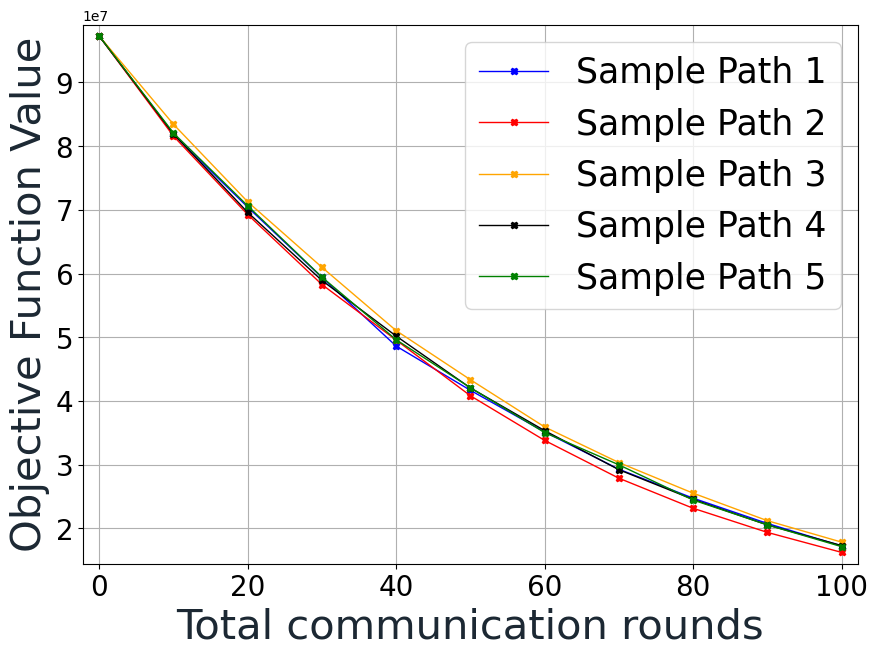

In [16]:
fig = plt.figure(figsize=(10,7))

#This is the line code
plt.plot(range(0,R+1, math.ceil(R / ep)), graphDatas[0], color='b',
         marker='X',markersize=5,linestyle='solid',label=("Sample Path 1"),linewidth=1)
plt.plot(range(0,R+1, math.ceil(R / ep)), graphDatas[1], color='r',
         marker='X',markersize=5,linestyle='solid',label=("Sample Path 2"),linewidth=1)
plt.plot(range(0,R+1, math.ceil(R / ep)), graphDatas[2], color='orange',
         marker='X',markersize=5,linestyle='solid',label=("Sample Path 3"),linewidth=1)
plt.plot(range(0,R+1, math.ceil(R / ep)), graphDatas[3], color='black',
         marker='X',markersize=5,linestyle='solid',label=("Sample Path 4"),linewidth=1)
plt.plot(range(0,R+1, math.ceil(R / ep)), graphDatas[4], color='g',
         marker='X',markersize=5,linestyle='solid',label=("Sample Path 5"),linewidth=1)

#General formatting code
plt.legend(loc=1,fontsize=25)
plt.xlabel('Total communication rounds', color='#1C2833',fontsize=30)
plt.ylabel('Objective Function Value', color='#1C2833',fontsize=30)
plt.xticks(np.linspace(0,R, math.ceil(6)),fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.margins(0.022)

plt.savefig('Revised Plots/No Title Binary.jpg')

# Testing

In [14]:
def my_confu_mat(opt_sol):
    pred_labels = np.zeros((N_test,1))
    for j in range(N_test):
        pred_labels[j][0] = np.sign(np.dot(U_test[:,[j]].T,opt_sol))
    return confusion_matrix(v_test.T, pred_labels)

def precision_score(opt_sol):
    confu_mat = my_confu_mat(opt_sol)
    return (confu_mat[0][0]+confu_mat[1][1])/(confu_mat[1][0]+confu_mat[0][1]+confu_mat[1][1]+confu_mat[0][0])

In [15]:
#Test Gradient Descent Precision Score
zMatrix, wVector = convert_x_to_z_and_w(final1)
ps_GD = precision_score(np.dot(zMatrix, wVector)) 

print("Test score for GD: ", "{0:.2%}".format(ps_GD))

NameError: name 'final1' is not defined